# Binary Image Classification - Detecting Pneumonia in X-Rays

The following dataset was derived from the following kaggle site: https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

The dataset contains a total of $5,863$ chest x-ray images belonging to a binary classification: those with pneumonia and those without. The goal is to predict whether or not the person has pneumonia given their chest x-ray. The original data was split into three directories: training, validation, and testing. The validation directory only contained 8 images, a very poor default, so the validation directory was merged to the training directory.

## How does the Algorithm Work?

A main problem with convolutional neural networks is designing the overal architecture of the network. We can 'automate' this process through advanced guided random search techniques, such as genetic algorithms. The algorithm uses a differential based genetic algorithm that works by taking directional information within the population to create offspring through crossover and mutation. The process can be broken down into the following steps:

- 1) Define Modules
- 2) Create Initial Population
- 3) Run Evolution Algorithm
- 4) Create Ensemble

In order to allow the algorithm to evolve the architecture, we need a way to supply the algorithm with basic building blocks, called modules in this library. Modules are basic building blocks containing how the structure of how the architecture should be designed. Inside the modules we can insert prior beliefs about how the architecture should be designed. For example, we can define a module to include a convolution layer, then pooling, batch norm, activation, and dropout in that order, where the differential algorithm has the ability to include the layers and if so, their respective hyper-parameters. 

After we create the modules, we need to create a large random sample initial population. The purpose of the initial population is to create as much diversity as possible to be fed into the differential algorithm. The portion of models created in the initial population should be around $10-20$% of the max number of models created for a given time constraint. 

After running the initial population, the best handful of individuals are used to create the initial generation for the differential algorithm and are evolved until the maximum number of generations have been reached.

After evolution, the final generation can be pooled together to form an ensemble of models. 

## For this Problem

For this problem, we will only create a total of 350 models, 50 for initial population, and 300 for evolution, 15 generation size for 20 generations. Because the dataset is relatively small, only $5000$ for training, there is no need to only train on a sample from the training set as in the cipher10 dataset. 


## Load Algorithms from Evolutionary Computation Library

In [1]:
from EvolutionaryComputation.AutoML.initial_populations import NetworkInitialPopulation
from EvolutionaryComputation.AutoML.modules import CustomConvolutionModule
from EvolutionaryComputation.AutoML.modules import CustomDeepModule
from EvolutionaryComputation.AutoML.modules import hyper_param_sample
from EvolutionaryComputation.AutoML.neural_network_architecture import NetworkArchitectureEvolution

## Load Other Necessary Libraries

In [2]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.callbacks import EarlyStopping, TerminateOnNaN
from tensorflow.keras.backend import clear_session
import numpy as np
import tensorflow as tf
import gc
import os
import pickle
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

## Load in Data

The x-ray images come in many different dimensions, from 720x640 to 1300x1200. As a result, all images will be reduced down to 256x256 in order to have the same dimensions for all images and to limit the strain on my poor little local GeForce GTX 980M GPU. 

In [3]:
data_dir = Path("chest_xray")

train_dir = data_dir / 'train'  # original 8 validation images were moved to training directory
test_dir = data_dir / 'test'  

normal_dir = train_dir / 'NORMAL'
pneumonia_dir = train_dir / 'PNEUMONIA'

normal_cases = normal_dir.glob("*.jpeg")
pneumonia_cases = pneumonia_dir.glob("*.jpeg")


train_x = []
train_y = []

for img in normal_cases:
    
    img2 = np.asarray(Image.open(img).convert("RGB").resize((256, 256)))
    train_x.append(img2)

    train_y.append(0)

for img in pneumonia_cases:
    img2 = np.asarray(Image.open(img).convert("RGB").resize((256, 256)))
    train_x.append(img2)
    

    train_y.append(1)

train_x = np.asarray(train_x)
train_y = np.asarray(train_y)

## View Data 

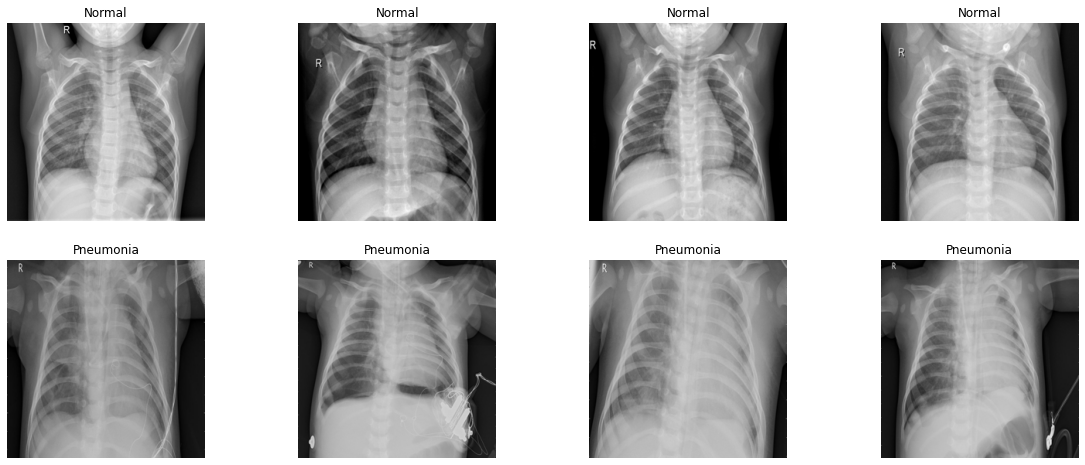

In [51]:
plt.figure(figsize=(20, 8))
for i in range(0, 8):
    plt.subplot(2, 4, i+1)
    plt.axis('off')
    if i <= 3:
        img = Image.fromarray(train_x[i], "RGB")
        plt.imshow(img)
        plt.title("Normal")
    else:
        img = Image.fromarray(train_x[3000+i], "RGB")
        plt.imshow(img)
        plt.title("Pneumonia")


## Class Balance Count

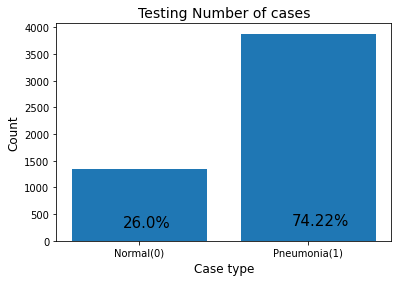

In [221]:
_, cases_count = np.unique(train_y, return_counts=True)
plt.figure()
plt.bar(range(0, 2), cases_count)
p = np.round(cases_count/np.sum(cases_count), 4)
plt.title('Testing Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.text(x=-0.1, y=250, s="{}%".format(np.round(p[0]*100), 4), fontsize=15)
plt.text(x=0.9, y=300, s="{}%".format(p[1]*100), fontsize=15)
plt.xticks(range(len(cases_count)), ['Normal(0)', 'Pneumonia(1)'])
plt.show()

As we can see from above, there exists a class imbalance between the number of occurrences for those with and without pneumonia. Because of this class imbalance, pure accuracy will not be a satisfactory measurement. Instead, $F_1$ score will be used, which is calculated by the following equation

$$
F_1=2*\frac{p+r}{p+r}=\frac{TP}{TP+0.5*(FP+FN)}
$$

Where $TP$ denotes True Postitives, $FP$ dentoes False Positives, $FN$ denotes False Negatives; and $p$ denotes precision and $r$ denotes recall. Precision, $TP/(TP+FP)$ denotes the percentage of times the model was correct when it predicted pneumonia. On the other hand, recall, $TP/(TP+FN)$ denotes the percentage of times the model correctly identified pneumonia. Recall and Precision are often at 'war' with each other, as increasing one will often drecreasing the other. In order to compromise, a surrogate metric has been created, the $F$ measure: 

$$
F=\frac{(1+\beta^2)TP}{(1+\beta^2)TP+\beta^2(FN+FP)}
$$

where it $\beta$ is usually assumed to be $1$, denoting the harmonic mean between precision and recall. Our goal will be to maximize this value, which ranges from $[0,1]$.


## Creating Validation Data
Because the original validation directory only contained 8 images, which is extremely low, it was merged with the training directory. Now, we need to create the validation data. For this problem $20$% of the training data will be split into validation. To do this, we will simply use indices rather than two seperate arrays.

In [7]:
n = len(train_x)
ind = list(range(0, n))
np.random.shuffle(ind)
val_ind = int(0.8*n)  # 80/20 split

train_ind = ind[0:val_ind]  # use indices for training/validation instead of two seperate datasets
val_ind = ind[val_ind:]

## 1) Creating the Modules

Now we need to create the modules. Each module will compose of a convolution layer, pooling, activation, batch norm, and dropout. The probability of including an activation, batch norm, or dropout layer will be $0.8$% per module. The probability of including the pooling layer will be shortly discussed. Because the image input dimension is larger than 32x32, as with the cipher10 example, then we might expect to need more than 2 modules per channel probability. In this example, we will have 3 modules per channel, $[16, 32, 64, 128, 256, 518]$, totalling to 18 modules/possible convolution layers. 

Because the input image size is 256x256 and the default stride for pooling is 2x2, the maximum number of pooling layers before a $1x1xouput\ channel$ is reached, is 8, as $2^8=256$. In this way, if more than 8 modules contain the pooling layer than the output will be a $1x1xoutput\ channel$. Therefore, because the output result will be the same for more than 8 modules including a pooling layer we can treat them the same. If less than 6 pooling layers are included then the output will be $8x8xoutput\ channel$, which is extremely large. Therefore, we need to find probabilities of including the pooling layer such that the majority of sampled models will have between 6 and 8 modules including the pooling layer.

The modules will be stacked such that there will be three consecutive modules per channel type. Because there is three modules per channel type, we can order the probabilities of including the pooling layer differently for each module per channel, $p1,p2,p3$:


| Module Number | Channel Count | Pooling Probability
| ---- | --- | --- | 
| 1 | 16 channels | p1 |
| 2 | 16 channels | p2 |
| 3 | 16 channels | p3 |
| 4 | 32 channels | p1 |
| 5 | 32 channels | p2 |
| 6 | 32 channels | p3 |
| 7 | 64 channels | p1 |
| 8 | 64 channels | p2 |
| 9 | 64 channels | p3 |
| 10 | 128 channels | p1 |
| 11 | 128 channels | p2 |
| 12 | 128 channels | p3 |
| 13 | 256 channels | p1 |
| 14 | 256 channels | p2 |
| 15 | 256 channels | p3 |
| 16 | 512 channels | p1 |
| 17 | 512 channels | p2 |
| 18 | 512 channels | p3 |

To help us determine the values for $p1,p2,p3$ we can use the `hyper_param_sample` function which takes in the module probabilities of being included and the hyper-paramter probabilities of being included, which in our case is the probabilities of including the pooling layer per module. 

We don't have to worry about the order of module nor hyper-param probabilities as we're only interested in seeing from a random sample how many times the hyper-paramter will be chosen to be included for the model.

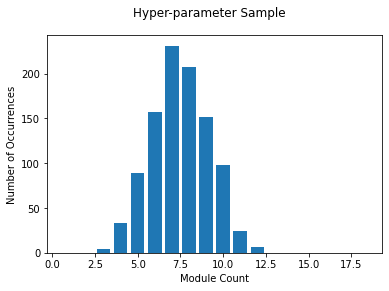

,,,,,,,,,,,,,,,,,,
Module Counts,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
Num of Occurrences,0,0,4,33,89,157,231,207,151,98,24,6,0,0,0,0,0,0


In [42]:
# define module probability - assume 18 modules with probability of 80% of being kept
mod_prob = [0.8]*18

# define hyper-param2probability - pooling in our example, order does not matter
p1 = 1
p2 = 0.45
p3 = 0.125
pool_prob = [p1]*6+[p2]*6+[p3]*6

hyper_param_sample(module_probs=mod_prob, hyper_param_prob=pool_prob, num_sample=1000)

After toying around the values for p1, p2, and p3 the following values yield the above random sample results. As we can see, only $12.6$% of the $1000$ randomly sampled models will include the pooling layer in less than 6 modules. While $48$% of the $1000$ randomly sampled models will include the pooling layer in more than 7 modules, resulting in an output size of $1x1xoutput\ channel$. However, $39.4$% of the $1000$ randomly sampled models have between 6 or 7 modules that include the pooling layer. Althought we cannot generate probabilities that yield results between 5 and 8 modules including the pooling layer, the following probabilities chosen above through toying around are promising and will be used for creating the modules below:

In [22]:
def create_conv_module(ch_prob, pool_prob, prob_include=0.8):   # add more parameters for choosing hyper param for each layer
    conv_module = CustomConvolutionModule(prob_include=prob_include)
    conv_module.addConvolution(channel_sizes=[16, 32, 64, 128, 256, 512], ch_prob=ch_prob)
    conv_module.addPooling(max_prob=0.50, avg_prob=0.50, prob_include=pool_prob)
    conv_module.addActivation(activations=['relu', 'leaky_relu', 'selu', 'elu'], activation_probs=[0.25]*4,prob_include=0.8)
    conv_module.addBatchNorm(prob_include=0.8)
    conv_module.addDropOut(prob_include=0.8, min_alpha=0.2, max_alpha=0.5)
    return conv_module

def create_deep_module():  # add parameters for choosing hyper param for each layer
    deep_module = CustomDeepModule(prob_include=0.75)
    deep_module.addDense(min_node=50, max_node=250, activations=['relu', 'leaky_relu', 'selu', 'elu'], activation_probs=[0.25]*4)
    deep_module.addBatchNorm(prob_include=0.75)
    deep_module.addDropOut(prob_include=0.75, min_alpha=0.2, max_alpha=0.5)
    return deep_module

p1 = 1
p2 = 0.45
p3 = 0.125

conv_modules = []  # 18 modules
conv_modules.append(create_conv_module(ch_prob=[1, 0, 0, 0, 0, 0], pool_prob=p1))  # always channel 16
conv_modules.append(create_conv_module(ch_prob=[1, 0, 0, 0, 0, 0], pool_prob=p2))  # always channel 16
conv_modules.append(create_conv_module(ch_prob=[1, 0, 0, 0, 0, 0], pool_prob=p3))  # always channel 16
conv_modules.append(create_conv_module(ch_prob=[0, 1, 0, 0, 0, 0], pool_prob=p1))  # always channel 32
conv_modules.append(create_conv_module(ch_prob=[0, 1, 0, 0, 0, 0], pool_prob=p2))  # always channel 32
conv_modules.append(create_conv_module(ch_prob=[0, 1, 0, 0, 0, 0], pool_prob=p3))  # always channel 32
conv_modules.append(create_conv_module(ch_prob=[0, 0, 1, 0, 0, 0], pool_prob=p1))  # always channel 64
conv_modules.append(create_conv_module(ch_prob=[0, 0, 1, 0, 0, 0], pool_prob=p2))  # always channel 64
conv_modules.append(create_conv_module(ch_prob=[0, 0, 1, 0, 0, 0], pool_prob=p3))  # always channel 64
conv_modules.append(create_conv_module(ch_prob=[0, 0, 0, 1, 0, 0], pool_prob=p1))  # always channel 128
conv_modules.append(create_conv_module(ch_prob=[0, 0, 0, 1, 0, 0], pool_prob=p2))  # always channel 128
conv_modules.append(create_conv_module(ch_prob=[0, 0, 0, 1, 0, 0], pool_prob=p3))  # always channel 128
conv_modules.append(create_conv_module(ch_prob=[0, 0, 0, 0, 1, 0], pool_prob=p1))  # always channel 256
conv_modules.append(create_conv_module(ch_prob=[0, 0, 0, 0, 1, 0], pool_prob=p2))  # always channel 256
conv_modules.append(create_conv_module(ch_prob=[0, 0, 0, 0, 1, 0], pool_prob=p3))  # always channel 256
conv_modules.append(create_conv_module(ch_prob=[0, 0, 0, 0, 0, 1], pool_prob=p1))  # always channel 512
conv_modules.append(create_conv_module(ch_prob=[0, 0, 0, 0, 0, 1], pool_prob=p2))  # always channel 512
conv_modules.append(create_conv_module(ch_prob=[0, 0, 0, 0, 0, 1], pool_prob=p3))  # always channel 512


deep_modules = []  # 2 modules
deep_modules.append(create_deep_module())
deep_modules.append(create_deep_module())

## Create F1 statistic

In [4]:
from tensorflow.keras import backend as K

def f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

## 2) Create Fitness Function for Initial Population

In [31]:
# fitness function to train and evaluate a given model
def fitness_function_init_pop(model, max_epoch=25):
    # callbacks based off early stopping
    callback = [EarlyStopping(monitor='loss', patience=4), EarlyStopping(monitor='val_loss', patience=4),
                 EarlyStopping(monitor='f1', patience=4, mode="max", restore_best_weights=True)]

    try:
        # compile model
        model.compile(optimizer='adam',
                      loss="binary_crossentropy",
                      metrics=['accuracy', f1])
        history = model.fit(train_x[train_ind], train_y[train_ind], batch_size=16, epochs=max_epoch,
                            verbose=0, callbacks=callback,
                            validation_data=(train_x[val_ind], train_y[val_ind]))

        f = np.nanmax(history.history['val_f1'])
        if np.isnan(f):
            f = -1
        v = np.nanmin(history.history['val_loss'])
        if np.isnan(v):
            v = 10000
            
        del model  # delete model to prevent lost memory

    except Exception as e:
        print("Model Architecture Failure")
        print(e)
        f = -1
        v = 10000
        gc.collect()  # call gargabe collection
        clear_session()  # clear tensorflow model
        tf.compat.v1.reset_default_graph()  # clear tensorflow model
    return f, v

## Run Initial Population 

50 randomly generated models will be created and tested. Remember, fitness is based off the highest $F_1$ score from the validation set

In [32]:
init_pop = NetworkInitialPopulation(convolution_module=conv_modules, deep_module=deep_modules,
                                    init_size=50, input_shape=(256, 256, 3), save_dir='saved_weights',
                                    num_output=1, output_act='sigmoid')

In [33]:
init_fit = init_pop.fitness(fitness_function=fitness_function_init_pop)

Model 1/50 - Expected Total Time Left: ???
   Best Model: 1 - Best: 0.9542, Top 5%: 0.9542, Top 10%: 0.9542, Top 15%: 0.9542, Top 20%: 0.9542
Model 2/50 - Expected Total Time Left: 6908.053 sec
   Best Model: 2 - Best: 0.9821, Top 5%: 0.9807, Top 10%: 0.9793, Top 15%: 0.9779, Top 20%: 0.9765
Model 3/50 - Expected Total Time Left: 11948.8671 sec
   Best Model: 2 - Best: 0.9821, Top 5%: 0.9793, Top 10%: 0.9765, Top 15%: 0.9737, Top 20%: 0.9709
Model 4/50 - Expected Total Time Left: 9823.1237 sec
   Best Model: 2 - Best: 0.9821, Top 5%: 0.9794, Top 10%: 0.9767, Top 15%: 0.974, Top 20%: 0.9712
Model 5/50 - Expected Total Time Left: 8878.2317 sec
   Best Model: 2 - Best: 0.9821, Top 5%: 0.9817, Top 10%: 0.9813, Top 15%: 0.9809, Top 20%: 0.9804
Model 6/50 - Expected Total Time Left: 10119.811 sec
   Best Model: 2 - Best: 0.9821, Top 5%: 0.9816, Top 10%: 0.9811, Top 15%: 0.9805, Top 20%: 0.98
Model 7/50 - Expected Total Time Left: 10313.2614 sec
   Best Model: 7 - Best: 0.9836, Top 5%: 0.9831

In [34]:
pickle.dump(init_pop, open("init_pop", "wb"))  # 3.5 hours

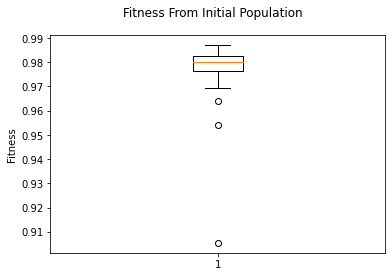

In [35]:
init_pop.plot()

As we can see from the results, the best model achieved a validation $F_1$ score of $0.987$, which is already an acceptable score. However, we can improve upon the randomly generated models througth the differential evolutionary algorithm.

## 3) Define Fitness Function For Evolution

In [55]:
def fitness_function_evolution(model, max_epoch=10):
   # callbacks based off early stopping
    callback = [EarlyStopping(monitor='loss', patience=3), EarlyStopping(monitor='val_loss', patience=3),
                 EarlyStopping(monitor='f1', patience=3, mode="max", restore_best_weights=True)]

    try:
        # compile model
        model.compile(optimizer='adam',
                      loss="binary_crossentropy",
                      metrics=['accuracy', f1])
        history = model.fit(train_x[train_ind], train_y[train_ind], batch_size=16, epochs=max_epoch,
                            verbose=0, callbacks=callback,
                            validation_data=(train_x[val_ind], train_y[val_ind]))

        f = np.nanmax(history.history['val_f1'])
        if np.isnan(f):
            f = -1
        v = np.nanmin(history.history['val_loss'])
        if np.isnan(v):
            v = 10000
            
        del model  # delete model to prevent lost memory

    except Exception as e:
        print("Model Architecture Failure")
        print(e)
        f = -1
        v = 10000
        gc.collect()  # call gargabe collection
        clear_session()  # clear tensorflow model
        tf.compat.v1.reset_default_graph()  # clear tensorflow model
    return f, v

## Run Evolution Algorithm

The best 15 individuals from the initial population will be selected to be evolved for 20 generations, totaling to $15*20=300$ models being created and tested.

In [56]:
network_evolve = NetworkArchitectureEvolution(initial_population=init_pop, gen_size=15)

In [57]:
network_evolve.evolve(find_max=True, max_iter=20, state_save=5, fitness_function=fitness_function_evolution)

Initial Generation : 
  Best Fit: 0.9870288968086243, Mean Fit: 0.9839510639508565, Worst Fit: 0.9820871949195862
Generation 0 - Model 15/15 - Expected Total Time Left: 45864.436 secc
  Best Fit: 0.9870288968086243, Mean Fit: 0.9844035545984904, Worst Fit: 0.9829661250114441
Generation 1 - Model 15/15 - Expected Total Time Left: 42299.1596 sec
  Best Fit: 0.9870288968086243, Mean Fit: 0.9846307635307312, Worst Fit: 0.9833279252052307
Generation 2 - Model 15/15 - Expected Total Time Left: 40621.0856 sec
  Best Fit: 0.9870288968086243, Mean Fit: 0.9847153822580973, Worst Fit: 0.9834321737289429
Generation 3 - Model 15/15 - Expected Total Time Left: 37446.0139 sec
  Best Fit: 0.9870288968086243, Mean Fit: 0.9850689331690471, Worst Fit: 0.9837669730186462
Generation 4 - Model 15/15 - Expected Total Time Left: 40565.2566 sec
  Best Fit: 0.9877985119819641, Mean Fit: 0.9855345487594604, Worst Fit: 0.9844353199005127
Generation 5 - Model 15/15 - Expected Total Time Left: 37309.2294 sec
  Best

In [59]:
pickle.dump(network_evolve, open("final_network", "wb"))  # 16 hours

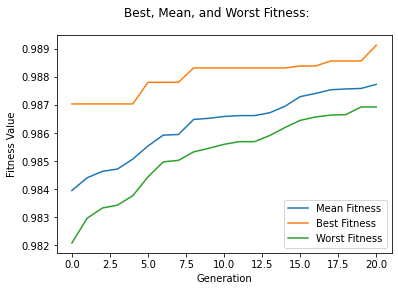

In [58]:
network_evolve.plot_evolution()

### Evolving Further
As we can see in the plot above of the F1 scores, our last generation acheived a jump in validation F1 score to $0.98911$. Because we have the time, we can evolve for a furthur 5 generations by using the `warm_start=True` option in `evolve`.

In [60]:
network_evolve.evolve(find_max=True, max_iter=5, state_save=5, fitness_function=fitness_function_evolution, warm_start=True)

Initial Generation : 
  Best Fit: 0.9891160726547241, Mean Fit: 0.9877258658409118, Worst Fit: 0.9869213700294495
Generation 20 - Model 15/15 - Expected Total Time Left: 38762.0868 sec
  Best Fit: 0.9891160726547241, Mean Fit: 0.9878230929374695, Worst Fit: 0.9870288968086243
Generation 21 - Model 15/15 - Expected Total Time Left: 37172.7991 sec
  Best Fit: 0.9894030094146729, Mean Fit: 0.9879859924316406, Worst Fit: 0.9871236681938171
Generation 22 - Model 15/15 - Expected Total Time Left: 36627.1379 sec
  Best Fit: 0.9894030094146729, Mean Fit: 0.9879859924316406, Worst Fit: 0.9871236681938171
Generation 23 - Model 15/15 - Expected Total Time Left: 35732.8072 sec
  Best Fit: 0.9894030094146729, Mean Fit: 0.9881057421366374, Worst Fit: 0.9873627424240112
Generation 24 - Model 15/15 - Expected Total Time Left: 34496.0408 sec
  Best Fit: 0.9894030094146729, Mean Fit: 0.9881057421366374, Worst Fit: 0.9873627424240112


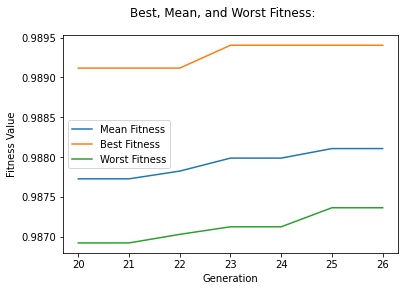

In [65]:
network_evolve.plot_evolution(starting_gen=20)

## 4) Create Ensemble From Last Generation

Now since we've finished evolution, it is time to create the ensemble from the last generation.

In [71]:
def fitness_function_ensemble(model, max_epoch=20):
   # callbacks based off early stopping
    callback = [EarlyStopping(monitor='loss', patience=5, restore_best_weights=True), EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
                 EarlyStopping(monitor='f1', patience=5, mode="max", restore_best_weights=True)]

    try:
        # compile model
        model.compile(optimizer='adam',
                      loss="binary_crossentropy",
                      metrics=['accuracy', f1])
        history = model.fit(train_x[train_ind], train_y[train_ind], batch_size=16, epochs=max_epoch,
                            verbose=0, callbacks=callback,
                            validation_data=(train_x[val_ind], train_y[val_ind]))

        f = np.nanmax(history.history['val_f1'])
        if np.isnan(f):
            f = -1
        v = np.nanmin(history.history['val_loss'])
        if np.isnan(v):
            v = 10000
            
        del model  # delete model to prevent lost memory - don't worry, model is still saved in network_evolve object

    except Exception as e:
        print("Model Architecture Failure")
        print(e)
        f = -1
        v = 10000
        gc.collect()  # call gargabe collection
        clear_session()  # clear tensorflow model
        tf.compat.v1.reset_default_graph()  # clear tensorflow model
    return f, v

In [73]:
network_evolve.create_ensemble(fitness_function=fitness_function_ensemble, find_max=True)  # 50 min

Model 1/15 - Expected Total Time Left: ???
Best Model: 1, Best: 0.9843840003013611, Mean: 0.9843840003013611, Worst: 0.9843840003013611
Model 2/15 - Expected Total Time Left: 1655.8807 sec
Best Model: 1, Best: 0.9843840003013611, Mean: 0.983885794878006, Worst: 0.9833875894546509
Model 3/15 - Expected Total Time Left: 1912.3233 sec
Best Model: 3, Best: 0.9850868582725525, Mean: 0.9842861493428549, Worst: 0.9833875894546509
Model 4/15 - Expected Total Time Left: 1896.0075 sec
Best Model: 3, Best: 0.9850868582725525, Mean: 0.9842671453952789, Worst: 0.9833875894546509
Model 5/15 - Expected Total Time Left: 1888.8804 sec
Best Model: 5, Best: 0.9908431172370911, Mean: 0.9855823397636414, Worst: 0.9833875894546509
Model 6/15 - Expected Total Time Left: 1680.1351 sec
Best Model: 5, Best: 0.9908431172370911, Mean: 0.9855483869711558, Worst: 0.9833875894546509
Model 7/15 - Expected Total Time Left: 1688.1097 sec
Best Model: 5, Best: 0.9908431172370911, Mean: 0.9854652796472821, Worst: 0.983387

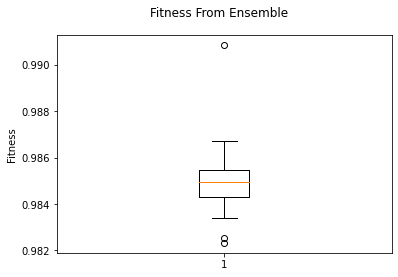

In [74]:
network_evolve.plot_ensemble()

# Visualizing Results

In [195]:
# mean of sigmoid values from ensemble
preds = network_evolve.ensemble_predict(train_x[val_ind], method='mean')

## Precision vs Recall Curve

In [9]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

In [180]:
prec = []
recal = []
for i in np.linspace(0.01, .99, 1000):
    classes = (preds > i).astype(int)
    prec.append(precision_score(train_y[val_ind], classes))
    recal.append(recall_score(train_y[val_ind], classes))

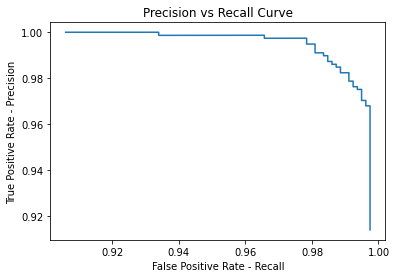

In [181]:
plt.plot(recal, prec)
plt.xlabel("False Positive Rate - Recall")
plt.ylabel("True Positive Rate - Precision")
plt.title("Precision vs Recall Curve")
plt.show()

## ROC - Curve

In [10]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [183]:
fpr, tpr, thresholds = roc_curve(train_y[val_ind], preds)
roc_auc = auc(fpr, tpr)

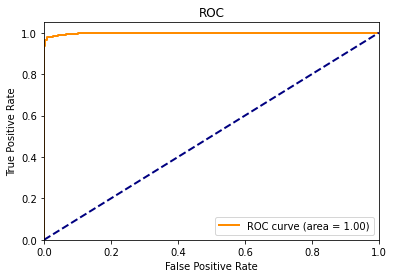

In [184]:
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

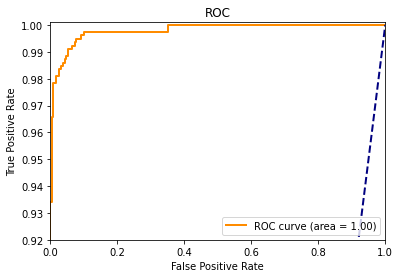

In [185]:
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.92, 1.001])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

## Best Threshold 
Calulated by simply finding the max value between the difference of TPR and FPR

In [186]:
optimal_idx = np.argmax(tpr-fpr)
optimal_threshold = thresholds[optimal_idx]
optimal_threshold

0.7783488

## Validation Statistics

In [199]:
classes = (preds > optimal_threshold).astype(int)
acc = accuracy_score(train_y[val_ind], classes)
f = f1_score(train_y[val_ind], classes)
r = recall_score(train_y[val_ind], classes)
p = precision_score(train_y[val_ind], classes) 

msg = "Validation Results: \n" \
      "  Accuracy: {}, F1 {}, Recall: {}, Precision: {}".format(acc, f, r, p)
print(msg)

Validation Results: 
  Accuracy: 0.9808978032473734, F1 0.987163029525032, Recall: 0.97712833545108, Precision: 0.9974059662775616


# Test Data Set Statistics

In [14]:
test_dir = data_dir / 'test'  # original 8 validation images were moved to testing directory

normal_dir = test_dir / 'NORMAL'
pneumonia_dir = test_dir / 'PNEUMONIA'

normal_cases = normal_dir.glob("*.jpeg")
pneumonia_cases = pneumonia_dir.glob("*.jpeg")


test_x = []
test_y = []

for img in normal_cases:
    
    img2 = np.asarray(Image.open(img).convert("RGB").resize((256, 256)))
    test_x.append(img2)
    test_y.append(0)

for img in pneumonia_cases:
    img2 = np.asarray(Image.open(img).convert("RGB").resize((256, 256)))
    test_x.append(img2)
    test_y.append(1)

test_x = np.asarray(test_x)
test_y = np.asarray(test_y)

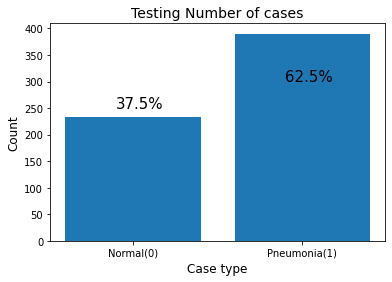

In [218]:
_, cases_count = np.unique(test_y, return_counts=True)
plt.figure()
plt.bar(range(0, 2), cases_count)
p = cases_count/np.sum(cases_count)
plt.title('Testing Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.text(x=-0.1, y=250, s="{}%".format(p[0]*100), fontsize=15)
plt.text(x=0.9, y=300, s="{}%".format(p[1]*100), fontsize=15)
plt.xticks(range(len(cases_count)), ['Normal(0)', 'Pneumonia(1)'])
plt.show()

In [189]:
# mean of sigmoid values from ensemble
preds = network_evolve.ensemble_predict(test_x, method='mean')

In [194]:
classes = (preds > optimal_threshold).astype(int)
acc = accuracy_score(test_y, classes)
f = f1_score(test_y, classes)
r = recall_score(test_y, classes)
p = precision_score(test_y, classes) 

msg = "Test Results: \n" \
      "  Accuracy: {}, F1 {}, Recall: {}, Precision: {}".format(acc, f, r, p)
print(msg)

Test Results: 
  Accuracy: 0.7772435897435898, F1 0.8474204171240395, Recall: 0.9897435897435898, Precision: 0.7408829174664108


Despite having extremely good validation results on 1047 validation images not used during training, the test results are not as good. The $F_1$ score is acceptable, while accuracy and precision are less than optimal. However, our recall value is extremely high, meaning that out of all the images with pneumonia, our model correctly identified $98.97$% of them, while only $74.088$% of the predicted images with pnemonia actually had it. Even though this false positive rate is a little high, it is acceptable in a medical industry where to not diagnose a person with pneumonia is better than to falsely diagnose them. 

# Comparing User-Defined Model

Although these results may not be as expecting, we can compare the results to that of other user-defined models. The following model was adapted from the following article by Abhinav Sagar: https://towardsdatascience.com/deep-learning-for-detecting-pneumonia-from-x-ray-images-fc9a3d9fdba8 . 

In [5]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Dropout, BatchNormalization, Flatten, Dense, \
    Activation, Input, SeparableConv2D

inputs = Input(shape=(256, 256, 3))

# First conv block
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Second conv block
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Third conv block
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Fourth conv block
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# Fifth conv block
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# FC layer
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(rate=0.7)(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(rate=0.3)(x)

# Output layer
output = Dense(units=1, activation='sigmoid')(x)

# Creating model and compiling
model = tf.keras.Model(inputs=inputs, outputs=output)
# callbacks based off early stopping
callback = [EarlyStopping(monitor='loss', patience=5, restore_best_weights=True), EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
         EarlyStopping(monitor='f1', patience=5, mode="max", restore_best_weights=True)]

# compile model
model.compile(optimizer='adam',
              loss="binary_crossentropy",
              metrics=['accuracy', f1])

print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
separable_conv2d (SeparableC (None, 128, 128, 32)      688       
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 128, 128, 32)      1344      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)      128   

In [8]:
history = model.fit(train_x[train_ind], train_y[train_ind], batch_size=16, epochs=50,
                    verbose=1, callbacks=callback,
                    validation_data=(train_x[val_ind], train_y[val_ind]))

Epoch 1/50
262/262 [==============================] - 60s 213ms/step - loss: 0.2837 - accuracy: 0.8800 - f1: 0.9186 - val_loss: 1.5503 - val_accuracy: 0.7526 - val_f1: 0.8556
Epoch 2/50
262/262 [==============================] - 55s 208ms/step - loss: 0.1669 - accuracy: 0.9424 - f1: 0.9596 - val_loss: 2.4563 - val_accuracy: 0.7526 - val_f1: 0.8556
Epoch 3/50
262/262 [==============================] - 54s 207ms/step - loss: 0.1215 - accuracy: 0.9558 - f1: 0.9690 - val_loss: 0.4541 - val_accuracy: 0.8338 - val_f1: 0.8978
Epoch 4/50
262/262 [==============================] - 54s 207ms/step - loss: 0.1012 - accuracy: 0.9654 - f1: 0.9752 - val_loss: 0.0985 - val_accuracy: 0.9694 - val_f1: 0.9779
Epoch 5/50
262/262 [==============================] - 54s 207ms/step - loss: 0.0941 - accuracy: 0.9692 - f1: 0.9783 - val_loss: 0.1203 - val_accuracy: 0.9656 - val_f1: 0.9743
Epoch 6/50
262/262 [==============================] - 54s 206ms/step - loss: 0.0888 - accuracy: 0.9716 - f1: 0.9800 - val_los

## Choosing Threshold Based off Validation

In [15]:
preds = model.predict(train_x[val_ind])

fpr, tpr, thresholds = roc_curve(train_y[val_ind], preds)
roc_auc = auc(fpr, tpr)
optimal_idx = np.argmax(tpr-fpr)
optimal_threshold = thresholds[optimal_idx]
optimal_threshold

0.7841426

## Validation Results

In [16]:
classes = (preds > optimal_threshold).astype(int)
acc = accuracy_score(train_y[val_ind], classes)
f = f1_score(train_y[val_ind], classes)
r = recall_score(train_y[val_ind], classes)
p = precision_score(train_y[val_ind], classes) 

msg = "Validation Results: \n" \
      "  Accuracy: {}, F1 {}, Recall: {}, Precision: {}".format(acc, f, r, p)
print(msg)

Validation Results: 
  Accuracy: 0.9656160458452722, F1 0.9768339768339768, Recall: 0.9631979695431472, Precision: 0.9908616187989556


## Test Results

In [17]:
preds = model.predict(test_x)
classes = (preds > optimal_threshold).astype(int)
acc = accuracy_score(test_y, classes)
f = f1_score(test_y, classes)
r = recall_score(test_y, classes)
p = precision_score(test_y, classes) 

msg = "Test Results: \n" \
      "  Accuracy: {}, F1 {}, Recall: {}, Precision: {}".format(acc, f, r, p)
print(msg)

Test Results: 
  Accuracy: 0.7564102564102564, F1 0.834061135371179, Recall: 0.9794871794871794, Precision: 0.7262357414448669


As we can see from both the validation and test results, our algoritm created an ensemble better than a user-defined model. The purpose of showing this is to reveal that other user-defined models struggled to achieve good test results.